# Reading a data set

In [ ]:
import networkx as nx
import numpy as np
import random as rd
import time
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt


data_source = '/content/soc-sign-epinions.txt'
dimensions = 32
learning_rate_init = 0.025
noise_size = 5
max_iterations = 10
p0 = 0.001

# Logistic regression function
def fa(x):
    if x > 15:
        tmp = 1
    else:
        tmp = p0 * np.exp(x) / (1 + p0 * (np.exp(x) - 1))
    return tmp

G = nx.DiGraph()
with open(data_path) as f:
    for line in f:
        line = line.strip().split()
        #print(int(line[2]))
        if int(line[2]) != 0:
            G.add_edge(int(line[0]), int(line[1]), weight=int(line[2]))

    
max_node_id = max(G.nodes())
undi_G = G.to_undirected()
nodes = list(G.nodes())
edges = np.array(G.edges())


edgeL=[]
with open(data_source) as f:
  ss_links=f.read().splitlines()

len(ss_links)

edgeL1=[]
edgeL2=[]
signVal=[]
for i in tqdm(ss_links):
  edgeL1.append(int(i.split()[0]))
  edgeL2.append(int(i.split()[1]))
  signVal.append(int(i.split()[2]))

ss_df=pd.DataFrame({"source": edgeL1, "destination": edgeL2, "sign":signVal})

ss_df.head()


100%|██████████| 841372/841372 [00:01<00:00, 608617.07it/s]


,source,destination,sign
0,0,1,-1
1,1,128552,-1
2,2,3,1
3,4,5,-1
4,4,155,-1


# Dataset Visualization

To understand Dataset nature

[123705, 717667]


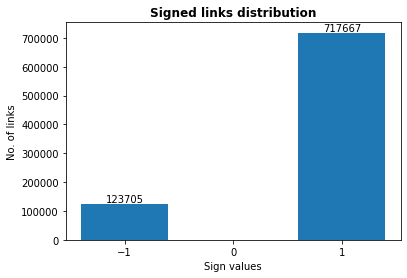

In [ ]:
import collections
c = collections.Counter(signVal)
c = sorted(c.items())

sign_num=[i[0] for i in c]
sign_freq=[i[1] for i in c]

print(sign_freq)

f, ax = plt.subplots()

plt.bar(sign_num, sign_freq)
plt.title("Signed links distribution", fontweight='bold')
plt.xlabel("Sign values")
plt.ylabel("No. of links")
ax.set_xticks(range(-1, 2))

for x,y in zip(sign_num,sign_freq):
    label = "{:}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,2), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


# Converting the dataset data frame into a numpy array

In [ ]:
edgeL=ss_df.to_numpy()



# Step 1: Learning SLF Vectors for each node pair in the given graph

### We learn the node embeddings in lower dimensions. This is also called Latent space embedding

In [ ]:
W_out_p = np.matrix(np.zeros((max_node_id + 1, dimensions)), dtype=np.float32)
W_in_p = np.matrix(np.zeros((max_node_id + 1, dimensions)), dtype=np.float32)
W_out_n = np.matrix(np.zeros((max_node_id + 1, dimensions)), dtype=np.float32)
W_in_n = np.matrix(np.zeros((max_node_id + 1, dimensions)), dtype=np.float32)

for i in nodes:
    for j in range(dimensions):
        W_out_p[i, j] = rd.uniform(0, 1)
        W_in_p[i, j] = rd.uniform(0, 1)
        W_out_n[i, j] = rd.uniform(0, 1)
        W_in_n[i, j] = rd.uniform(0, 1)

start = time.time()
for count in range(max_iterations):
    learning_rate = learning_rate_init * (max_iterations - count) / max_iterations
    for u in nodes:
        out_p_vec = np.zeros((1, dimensions))
        out_n_vec = np.zeros((1, dimensions))
        in_p_vec = np.zeros((1, dimensions))
        in_n_vec = np.zeros((1, dimensions))

        succs = G.successors(u)
        for succ in succs:
            e_p = fa(W_out_p[u] @ W_in_p[succ].T)
            e_n = fa(W_out_n[u] @ W_in_n[succ].T)
            if G[u][succ]['weight'] == 1:
                out_p_vec += (1 - e_p) * W_in_p[succ]
                out_n_vec -= e_n * W_in_n[succ]
            elif G[u][succ]['weight'] == -1:
                out_p_vec -= e_p * W_in_p[succ]
                out_n_vec += (1 - e_n) * W_in_n[succ]
            elif G[u][succ]['weight'] == 0:
                out_p_vec += (1 - e_p) * W_in_p[succ]
                out_n_vec += (1 - e_n) * W_in_n[succ]
        for i in range(noise_size):
            noise = rd.choice(nodes)
            while noise in succs:
                noise = rd.choice(nodes)
            e_p = fa(W_out_p[u] @ W_in_p[noise].T)
            e_n = fa(W_out_n[u] @ W_in_n[noise].T)
            out_p_vec -= e_p * W_in_p[noise]
            out_n_vec -= e_n * W_in_n[noise]
            
        pres = G.predecessors(u)
        for pre in pres:
            e_p = fa(W_out_p[pre] @ W_in_p[u].T)
            e_n = fa(W_out_n[pre] @ W_in_n[u].T)
            if G[pre][u]['weight'] == 1:
                in_p_vec += (1 - e_p) * W_out_p[pre]
                in_n_vec -= e_n * W_out_n[pre]
            elif G[pre][u]['weight'] == -1:
                in_p_vec -= e_p * W_out_p[pre]
                in_n_vec += (1 - e_n) * W_out_n[pre]
            elif G[pre][u]['weight'] == 0:
                in_p_vec += (1 - e_p) * W_out_p[pre]
                in_n_vec += (1 - e_n) * W_out_n[pre]
        for i in range(noise_size):
            noise = rd.choice(nodes)
            while noise in pres:
                noise = rd.choice(nodes)
            e_p = fa(W_out_p[noise] @ W_in_p[u].T)
            e_n = fa(W_out_n[noise] @ W_in_n[u].T)
            in_p_vec -= e_p * W_out_p[noise]
            in_n_vec -= e_n * W_out_n[noise]

        W_out_p[u] += learning_rate * out_p_vec
        W_in_p[u] += learning_rate * in_p_vec
        W_out_n[u] += learning_rate * out_n_vec
        W_in_n[u] += learning_rate * in_n_vec

        # Set the negative elements of U(out,u) , U(in,u) ,W(out,u) and W(in,u) to 0.
        for i in range(dimensions):
            if W_out_p[u, i] < 0:
                W_out_p[u, i] = 0
            if W_in_p[u, i] < 0:
                W_in_p[u, i] = 0
            if W_out_n[u, i] < 0:
                W_out_n[u, i] = 0
            if W_in_n[u, i] < 0:
                W_in_n[u, i] = 0

    end = time.time()
    print('count' + str(count) + ' : ' + str(round(end - start, 1)) + 's')


count0 : 342.5s


# Step 2: Concatenate SLF Vectors for all nodes. 'u'



### SLF Vectors are 

W_out_p(U out(u)): Positive outward SLF vectors

W_in_p(U in(u)):   Positive inward SLF vectors

W_out_n(W out(u)): Negative outward SLF vectors

W_in_n(W in(u)):   Negative inward SLF vectors













In [ ]:
W_out = np.matrix(np.zeros((max_node_id + 1, dimensions * 2)), dtype=np.float32)
W_in = np.matrix(np.zeros((max_node_id + 1, dimensions * 2)), dtype=np.float32)
for i in range(max_node_id + 1):
    W_out[i, : dimensions] = W_out_p[i]
    W_out[i, dimensions: dimensions * 2] = W_out_n[i]
    W_in[i, : dimensions] = W_in_p[i]
    W_in[i, dimensions: dimensions * 2] = W_in_n[i]

# Uncomment this to save the SLF vectors (Node Embeddings)
#np.savetxt(data_path + 'SLF_Out', W_out)
#np.savetxt(data_path + 'SLF_in', W_in)


### Sample SLF Vector with 64 dimensions for node 0

In [ ]:
print(W_out[0])
type(W_out.shape[1])

[[0.24679017 0.73754156 0.17252375 0.5619018  0.5555988  0.42216095
  0.37011382 0.17304347 0.87912065 0.8329392  0.6059754  0.49694285
  0.         0.7945125  0.82383096 0.57975256 0.74353623 0.08798787
  0.91990525 0.13449763 0.72455376 0.63372976 0.89008886 0.35901862
  0.76775354 0.56422466 0.7808063  0.7407487  0.3642811  0.48924738
  0.34492186 0.92968476 0.0269198  0.3194253  0.5808581  0.00953718
  0.02201529 0.287224   0.5659337  0.2939692  0.6293691  0.5830337
  0.38059622 0.46272495 0.52752227 0.16605392 0.8305154  0.71667117
  0.74020773 0.5841377  0.37833497 0.5510487  0.3930687  0.6423734
  0.45648673 0.00961151 0.12232254 0.02396536 0.69822395 0.7082905
  0.83273596 0.20562437 0.10685264 0.7418376 ]]


int

### Train and test dataset split representation 

In [ ]:
from sklearn.model_selection import train_test_split

train_edges, test_edges = train_test_split(edgeL,test_size=0.3,random_state=16)

for i, edge in enumerate(train_edges):
  if(i==0):
    print(edge)
    print(i)
    print(edge[0], edge[1],edge[2])
    print(type(edge[0]))

[11824 56146     1]
0
11824 56146 1
<class 'numpy.int64'>


# Step 3: Combining(Concatenating) the node pair features for nodes u, v as a pair- pair(u,v) 


In other words, it is nothing but Node feature Extraction

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

train_edges, test_edges, = train_test_split(edgeL,test_size=0.3,random_state=16)    
    
out_dim = int(W_out.shape[1])from sklearn.linear_model import LogisticRegression

in_dim = int(W_in.shape[1])
train_x = np.zeros((len(train_edges), (out_dim + in_dim) * 2))
train_y = np.zeros((len(train_edges), 1))

for i, edge in enumerate(train_edges):
    u = int(edge[0])
    v = int(edge[1])
    train_x[i, : out_dim] = W_out[u]
    train_x[i, out_dim: out_dim + in_dim] = W_in[u]
    train_x[i, out_dim + in_dim: out_dim * 2 + in_dim] = W_out[v]
    train_x[i, out_dim * 2 + in_dim:] = W_in[v]
    if int(edge[2]) > 0:
        train_y[i] = 1
    else:
        train_y[i] = -1

test_x = np.zeros((len(test_edges), (out_dim + in_dim) * 2))
test_y = np.zeros((len(test_edges), 1))
for i, edge in enumerate(test_edges):
    u = int(edge[0])
    v = int(edge[1])
    test_x[i, : out_dim] = W_out[u]
    test_x[i, out_dim: out_dim + in_dim] = W_in[u]
    test_x[i, out_dim + in_dim: out_dim * 2 + in_dim] = W_out[v]
    test_x[i, out_dim * 2 + in_dim:] = W_in[v]
    if int(edge[2]) > 0:
        test_y[i] = 1
    else:
        test_y[i] = -1



# Step 4: Training the Model and Making Predictions

###1. Logistic Regression:

Model training iteration time : 163.7s
Accuracy of Logistic regression model is  91.9 %
The AUC Score of Logistic regression classification model is : 80.0 %


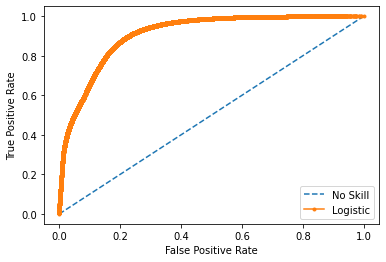

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
start = time.time()

ss = StandardScaler()
train_x = ss.fit_transform(train_x)
test_x = ss.fit_transform(test_x)
lr = LogisticRegressionCV(fit_intercept=True, max_iter=100, multi_class='multinomial', Cs=np.logspace(-2, 2, 20),
                          cv=2, penalty="l2", solver="lbfgs", tol=0.01)
lr.fit(train_x, train_y.ravel())
pred_prob = lr.predict(test_x)


end = time.time()
print('Model training iteration time : ' + str(round(end - start, 1)) + 's') 

accuracy = accuracy_score(test_y.ravel(),pred_prob)

print("Accuracy of Logistic regression model is ",str(round(accuracy*100,1)),"%")

performance_val=roc_auc_score(test_y, pred_prob)
print("The AUC Score of Logistic regression classification model is :" ,str(round(performance_val,1)*100),"%")

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_y))]

lr_probs = lr.predict_proba(test_x)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_y.ravel(), ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_y.ravel(), lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

[[ 41989  56031      1]
 [ 59586  51362      1]
 [  1687   3176      1]
 ...
 [125625  17002      1]
 [ 11854  11855      1]
 [ 11871  56137      1]]
[24516, 227896]


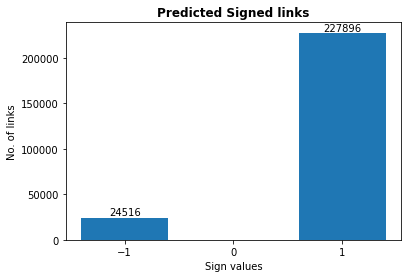

In [ ]:
pred_prob = lr.predict(test_x)

print(test_y)

predicted_links=[]



import collections
c = collections.Counter(pred_prob)
c = sorted(c.items())

sign_num=[i[0] for i in c]
sign_freq=[i[1] for i in c]

print(sign_freq)

f, ax = plt.subplots()

plt.bar(sign_num, sign_freq)
plt.title("Predicted Sign links", fontweight='bold')
plt.xlabel("Sign values")
plt.ylabel("No. of links")
ax.set_xticks(range(-1, 2))

for x,y in zip(sign_num,sign_freq):
    label = "{:}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,2), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


### 2. LightGBM

[1]	valid_0's auc: 0.8811
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.902824
[3]	valid_0's auc: 0.910202
[4]	valid_0's auc: 0.912804
[5]	valid_0's auc: 0.914737
[6]	valid_0's auc: 0.917514
[7]	valid_0's auc: 0.918989
[8]	valid_0's auc: 0.92047
[9]	valid_0's auc: 0.922024
[10]	valid_0's auc: 0.923437
[11]	valid_0's auc: 0.924397
[12]	valid_0's auc: 0.925201
[13]	valid_0's auc: 0.925986
[14]	valid_0's auc: 0.927112
[15]	valid_0's auc: 0.927474
[16]	valid_0's auc: 0.927983
[17]	valid_0's auc: 0.928512
[18]	valid_0's auc: 0.929043
[19]	valid_0's auc: 0.929802
[20]	valid_0's auc: 0.930554
[21]	valid_0's auc: 0.931081
[22]	valid_0's auc: 0.931673
[23]	valid_0's auc: 0.932243
[24]	valid_0's auc: 0.932762
[25]	valid_0's auc: 0.933154
[26]	valid_0's auc: 0.933541
[27]	valid_0's auc: 0.933947
[28]	valid_0's auc: 0.934426
[29]	valid_0's auc: 0.934874
[30]	valid_0's auc: 0.935207
[31]	valid_0's auc: 0.935748
[32]	valid_0's auc: 0.936126
[33]	valid_0's auc: 0.

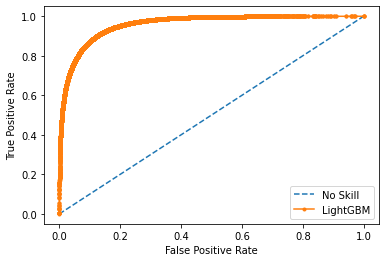

In [ ]:
import lightgbm as lgb

train_data = lgb.Dataset(train_x, train_y.ravel())
test_data = lgb.Dataset(test_x, test_y.ravel())

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

start=time.time()
# train lightGBM model
model = lgb.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

stop=time.time()

lgbm_prob=model.predict(test_x)

print(lgbm_prob[0:5])
for i in range(0,252412):
    if lgbm_prob[i]>=.5:       # setting threshold to .5
       lgbm_prob[i]=1
    else:  
       lgbm_prob[i]=0

print(lgbm_prob[0:5])
accuracy_lgbm = accuracy_score(lgbm_prob,test_y.ravel())

print("Accuracy of LightGBM model is ", str(round(accuracy_lgbm*100,1)),"%")

performance_val=roc_auc_score(test_y, lgbm_prob)
print("The AUC Score of LightGBM model is :" ,str(round(performance_val,1)*100),"%")

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_y))]

lgb_probs = model.predict(test_x)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_y.ravel(), ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_y.ravel(), lgb_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LightGBM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()